In [198]:
# Import headers
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from scipy import signal
from scipy.optimize import curve_fit
from qutip import *


In [199]:
# Open data file
# This is some test file
data = sio.loadmat(r"\\nyx.caltech.edu\painter\LabberData_DF5\QM_Data_DF5\2023\08\Data_0818\UA_Q2_RR_spec_flux_sweep_0818-1703.mat")

In [314]:
def Phi_flux_RR(flux, c, phi0):
    # Argument for the cosine flux tuning curve
    return 2*np.pi*c*flux + phi0

def ham(flux, out, wr, Ec, Ej, c, phi0, g):
    # Hamiltonian function
    # The flux is the independent variable
    # The following are fitting parameters: wr, Ec, Ej, c, phi0, g
    # The output is the resonator frequency for all the input flux values
    # The output frequency array is in units of MHz

    N = 4 # 0-3 photons

    a = tensor(destroy(N), qeye(N)) # cavity mode
    b = tensor(qeye(N), destroy(N)) # qubit

    f_ham = []

    # Hamiltonian as a function of flux
    for k in range(np.size(flux)):
        H = wr*a.dag()*a + (np.sqrt(8*Ec*Ej*np.abs(np.cos(Phi_flux_RR(flux[0][k],c, phi0))))-Ec)*b.dag()*b - Ec/2*b.dag()*b.dag()*b*b + g*(a*b.dag()+a.dag()*b)
        w, v = np.linalg.eig(H)
        
        for n_1 in range(v.shape[1]):
            v[:,n_1] = v[:,n_1]/np.inner(v[:,n_1],v[:,n_1])

            idx_00 = np.argmax(np.abs(v[0,:])) # |0,0>
            idx_01 = np.argmax(np.abs(v[N,:])) # |1,0> photon
            idx_02 = np.argmax(np.abs(v[1,:])) # |0,1> qubit
        match out:
                case 1:
                    f_ham.append(np.abs(np.maximum(w[idx_01],w[idx_02]) - w[idx_00]))
                case 2:
                    f_ham.append(np.abs(np.minimum(w[idx_01],w[idx_02]) - w[idx_00]))
    f_ham = np.array(f_ham)
    return f_ham

def ESR_4th(arr_sz, num_steps, SS, *popt):
    # Function that creates a flux array based on two input parameters:
    # arr_sz: endpoint of array. Since it is symmetric, it is the same value
    # num_steps: number of flux points 
    # fits that to a Hamiltonian shifted by the SS so that it is centered at zero
    # and uses this to perform a fit to a fourth order polynomial with only even terms.
    # The function finally outputs the ESR frequencies as a function of flux
    x_fit_r = np.array([np.linspace(-arr_sz, arr_sz, num_steps)])
    y_fit_r = ham(x_fit_r - np.abs(SS), 2, *popt)
    Q_fit_p4_r = np.polyfit(x_fit_r[0], y_fit_r, 4)
    return Q_fit_p4_r[0]* x_fit_r**4 + Q_fit_p4_r[2] * x_fit_r**2 + Q_fit_p4_r[4]


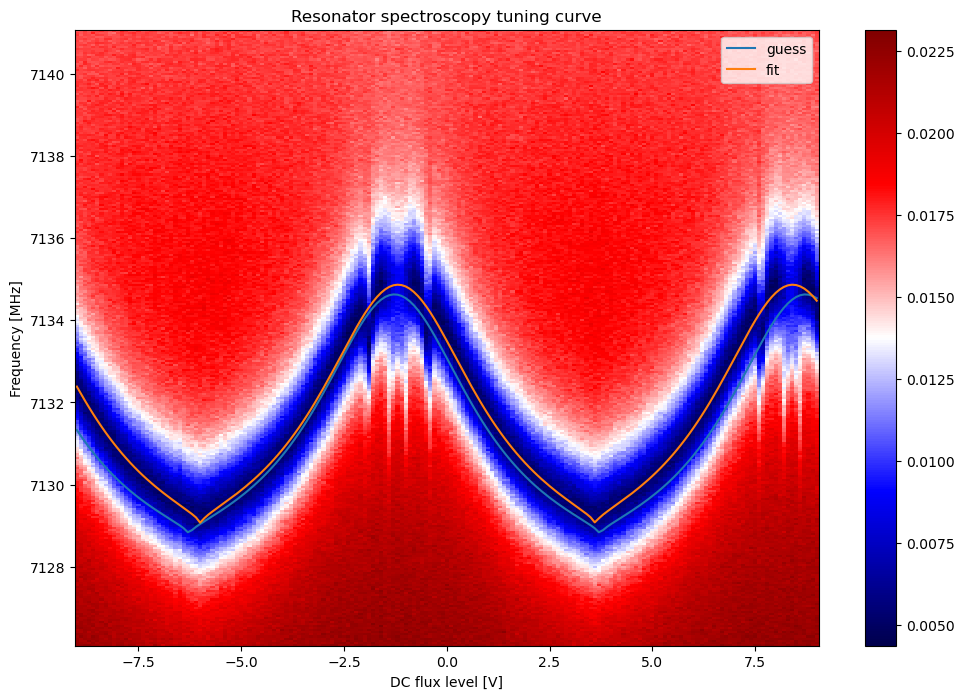

In [276]:
# This plots the result of the RR tuning curve as well as the fitting using the Hamiltonian

# Initial guess
wr = 7128 # Resonator frequency
Ec = 170.080 # Capacitive energy
Ej = 30642.9 # Inductive energy 
c = 0.05 # Period in cosine function for flux
phi0 = 0.4 # Offset in cosine function for flux
g = 74.965 # RR-qubit coupling

# Load data
freq = data['RR_freq']
flux = data['dc_flux_sweep']
sig = data['sig']
phase = data['sig_phase']
sig = np.reshape(sig, (np.size(flux), np.size(freq)))
phase = np.reshape(phase, (np.size(flux), np.size(freq)))

fig = plt.figure()
plt.rcParams['figure.figsize'] = [12, 8]
plt.cla()

# 2D spectroscopy plot
plt.title("Resonator spectroscopy tuning curve")
plt.pcolormesh( np.linspace(np.min(flux), np.max(flux), np.size(flux)),np.linspace(np.min(freq), np.max(freq), np.size(freq))/1e6, sig.T, shading="nearest", cmap="seismic")
plt.xlabel("DC flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()

# Array of initial guess
guess = [wr, Ec, Ej, c, phi0, g]

# Frequency output from hamiltonian function using initial guess
freq_fit_guess = ham(flux, 1, *guess)

# Plot of initial guess
plt.plot(flux.T, freq_fit_guess)

# Determine minima of signal to use as ydata for fitting
minimas = []
min_sig = []
for i in range(np.size(flux)):
    minimas.append(freq[0][np.argmin(sig[i])])
minimas = np.array(minimas)
min_sig = np.array(min_sig)

## Plot minima of signal
# plt.scatter(flux.T, minimas/1e6)

minimas_mhz = minimas/1e6

# Fit data from minima of signal to Hamiltonian function
# Initial guess is given by p0
# Bounds are necessary. The order is bounds = ((min_wr, min_Ec, min_Ej, min_c, min_phi0, min_g), (max_wr, max_Ec, max_Ej, max_c, max_phi0, max_g))
popt, _ = curve_fit(lambda flux, *guess: ham(flux, 1, *guess), xdata = flux, ydata = minimas_mhz, p0=guess, check_finite = "true", bounds = ((wr-200, Ec-100, Ej-20000, 0.0001, -4, g-50),(wr+200, Ec+100 ,Ej+ 20000, 4, 4, g+50)))

# This is the frequency output from the fitted data
freq_fit = ham(flux, 1, *popt)

# Plot the fitted data
plt.plot(flux.T, freq_fit)

plt.legend(["guess", "fit"])
plt.show()

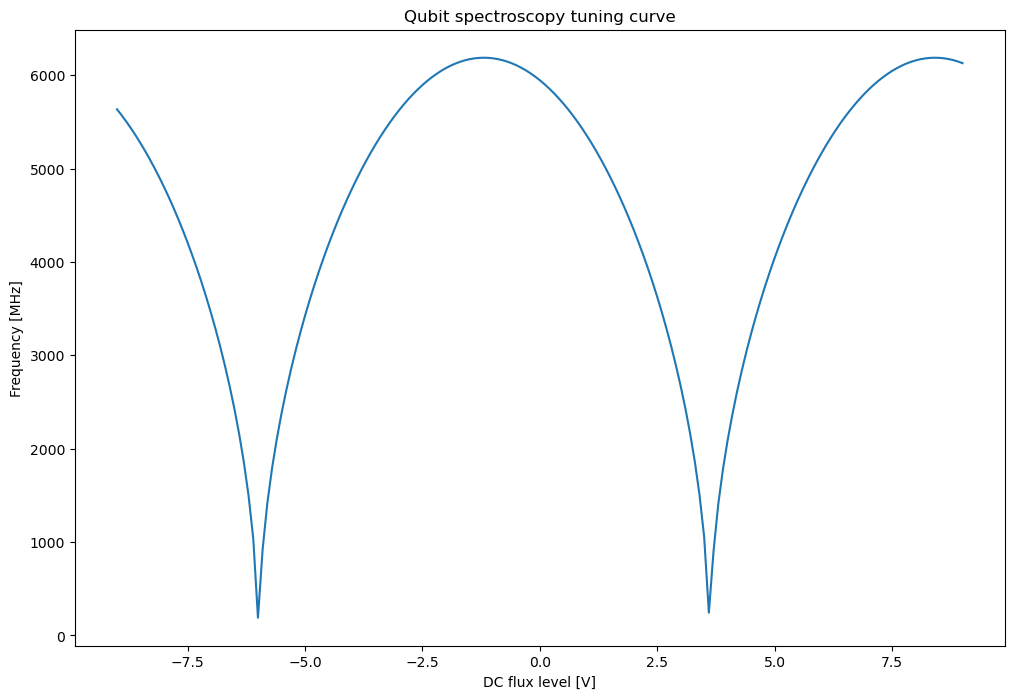

In [297]:
# Fitted ESR plot
freq_fit_qubit = ham(flux, 2, *popt)

plt.title("Qubit spectroscopy tuning curve")
plt.plot(flux.T, freq_fit_qubit)
plt.xlabel("DC flux level [V]")
plt.ylabel("Frequency [MHz]")

# SS from fitting to Hamiltonian parameters
SS = (-popt[4])/(2*np.pi*popt[3])

qubit parameters a*(flux+b)^2+c... 

a = -174.616

b (SS) = -1.188762

c (ESR) = 6191.2



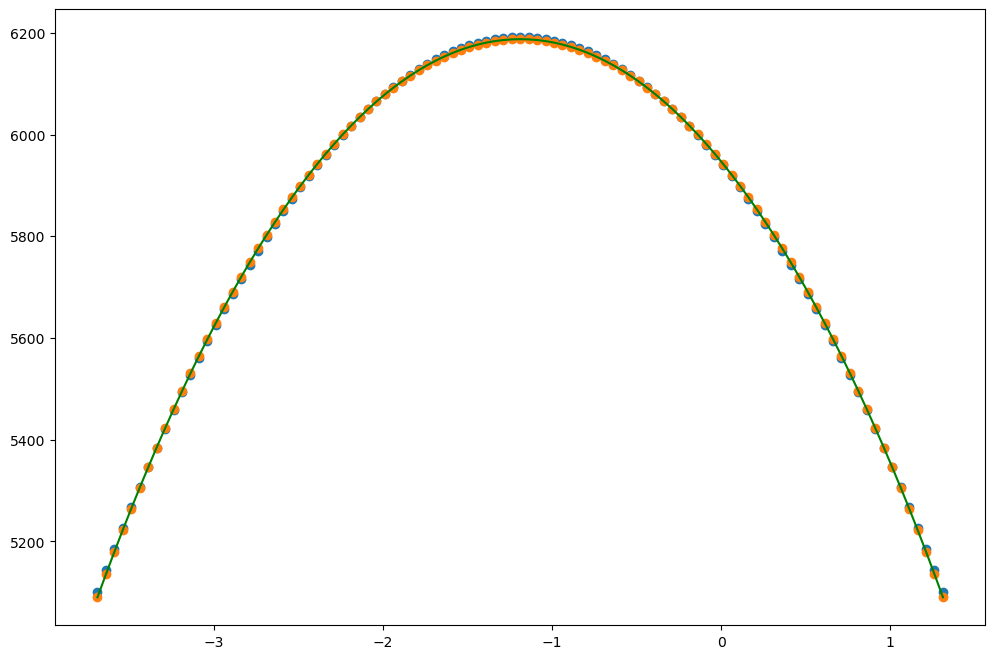

In [301]:
# Fit ESR to a parabola centered at the SS
num_steps = 101
arr_sz = 2.5 # Choose half of the size we will sweep around SS
# Make an array for the flux to be used in the poly fitting mirrored around the SS
x_fit = np.array([np.linspace(SS- arr_sz, SS + arr_sz, num_steps)])
y_fit = ham(x_fit, 2, *popt)
plt.plot(x_fit.T, y_fit, color='green')

# Fit to polynomial of second order
Q_fit_p2 = np.polyfit(x_fit[0], y_fit, 2)
plt.scatter(x_fit[0], np.polyval(Q_fit_p2, x_fit).T)
print('qubit parameters a*(flux+b)^2+c... \n')
a = Q_fit_p2[0]
b = -Q_fit_p2[1]/2/Q_fit_p2[0]
c = np.polyval(Q_fit_p2,-Q_fit_p2[1]/2/Q_fit_p2[0])
print('a = %.3f\n' % a)
print('b (SS) = %.6f\n' % b)
print('c (ESR) = %.1f\n' % c)

# Fit to polynomial of fourth order
y_fit2 = ham(x_fit, 2, *popt)
Q_fit_p4 = np.polyfit(x_fit[0], y_fit2, 4)
plt.scatter(x_fit[0], np.polyval(Q_fit_p4, x_fit).T)


In [303]:
# Shift SS to be at 0 V, as ff is relative to the SS
x_fit_r = np.array([np.linspace(-arr_sz, arr_sz, num_steps)])
y_fit_r = ham(x_fit_r-np.abs(SS), 2, *popt)
Q_fit_p4_r = np.polyfit(x_fit_r[0], y_fit_r, 4)
print(Q_fit_p4_r)

[-1.10598099e+00 -5.95132100e-14 -1.68574696e+02  3.71025684e-13
  6.18734270e+03]


In [328]:
# Test of fourth order polynomial fitting function 
# Need to pre define the number of points in the fitting function (num_steps) and create a symmetric
num_steps = 199
arr_sz = 0.99
ESR_freqs = ESR_4th(arr_sz, num_steps, SS, *popt)
